In [1]:
import sys
sys.path.append("..")

In [2]:
%load_ext cython
import numpy as np
import re
import pickle

In [15]:
number = r"[+\-]?(?:0|[1-9]\d*)(?:\.\d*)?(?:[eE][+\-]?\d+)?"
vector = r"\[(%s),(%s),(%s),(%s)\]" % (number, number, number, number)

def dat2arrays(filename, out):   
    with open(filename, "r") as f:
        for line in f:
            if line.startswith("HADS: "):
                e = []
                
                for p in re.findall(vector, line):
                    e.append([float(p[0]), float(p[1]), float(p[2]), float(p[3])])
                    
                e = np.array(e)
                
                pickle.dump(e, out, protocol=2)

In [3]:
%%cython -f -+ -I/usr/local/include --link-args=-Wl,-rpath,/usr/local/lib -lm -L/usr/local/lib -lfastjettools -lfastjet -lfastjetplugins -lsiscone_spherical -lsiscone
import numpy as np
cimport numpy as np
np.import_array()

from libcpp.pair cimport pair
from libcpp.vector cimport vector

cdef extern from "/home/gilles/gdrive/research/sandbox/learning-qcd-rnn/notebooks/fj.cc":
    void fj(vector[double]& a, 
            vector[vector[int]]& trees, 
            vector[vector[double]]& contents, 
            vector[double]& masses, 
            vector[double]& pts, 
            double R, int jet_algorithm)
    
cpdef cluster(np.ndarray[np.double_t, ndim=2, mode="c"] a, 
              R=1.0, jet_algorithm=0):
    cdef vector[double] v
    cdef vector[vector[int]] trees
    cdef vector[vector[double]] contents
    cdef vector[double] masses
    cdef vector[double] pts 
    for value in a.ravel():
        v.push_back(value)
    
    fj(v, trees, contents, masses, pts, R=R, jet_algorithm=jet_algorithm)
    jets = []
    
    for tree, content, mass, pt in zip(trees, contents, masses, pts):
        tree = np.array([e for e in tree]).reshape(-1, 2)
        content = np.array([e for e in content]).reshape(-1, 4)
        jets.append((tree, content, mass, pt))
        
    return jets

In [4]:
import copy
from rootpy.vector import LorentzVector
from recnn.preprocessing import _pt

def preprocess(jet, output="kt", trimming=0.0):
    jet = copy.deepcopy(jet)
    constituents = jet["content"][jet["tree"][:, 0] == -1] 

    # run kt (R=0.3) on the constituents c of j, resulting in subjets sj1, sj2, ..., sjN
    subjets = cluster(constituents, R=0.3, jet_algorithm=0)
    
    # trimming
    if trimming > 0.0:
        subjets = [(tree, content, mass, pt) for tree, content, mass, pt in subjets if pt > trimming * jet["pt"]]
    else:
        subjets = [(tree, content, mass, pt) for tree, content, mass, pt in subjets]
    
    # phi = sj1.phi()
    # for all c, do c.rotate_z(-phi)
    v = subjets[0][1][0]
    v = LorentzVector(v)
    phi = v.phi()
    
    for _, content, _, _ in subjets:
        for i in range(len(content)):
            v = LorentzVector(content[i])
            v.rotate_z(-phi)
            content[i, 0] = v[0]
            content[i, 1] = v[1]
            content[i, 2] = v[2]
            content[i, 3] = v[3]
            
    # bv = sj1.boost_vector()
    # bv.set_perp(0)
    # for all c, do c.boost(-bv)
    v = subjets[0][1][0]
    v = LorentzVector(v)
    bv = v.boost_vector()
    bv.set_perp(0)
    
    for _, content, _, _ in subjets:        
        for i in range(len(content)):
            v = LorentzVector(content[i])
            v.boost(-bv)
            content[i, 0] = v[0]
            content[i, 1] = v[1]
            content[i, 2] = v[2]
            content[i, 3] = v[3]
    
    # deltaz = sj1.pz - sj2.pz
    # deltay = sj1.py - sj2.py
    # alpha = -atan2(deltaz, deltay)
    # for all c, do c.rotate_x(alpha)
    if len(subjets) >= 2:
        deltaz = subjets[0][1][0, 2] - subjets[1][1][0, 2]
        deltay = subjets[0][1][0, 1] - subjets[1][1][0, 1]
        alpha = -np.arctan2(deltaz, deltay)

        for _, content, _, _ in subjets:
            for i in range(len(content)):
                v = LorentzVector(content[i])
                v.rotate_x(alpha)
                content[i, 0] = v[0]
                content[i, 1] = v[1]
                content[i, 2] = v[2]
                content[i, 3] = v[3]
    
    # if sj3.pz < 0: for all c, do c.set_pz(-c.pz)
    if len(subjets) >= 3 and subjets[2][1][0, 2] < 0:
        for _, content, _, _ in subjets:
            for i in range(len(content)):
                content[i, 2] *= -1.0
                
    # finally recluster all transformed constituents c into a single jet 
    constituents = []
    
    for tree, content, _, _ in subjets:
        constituents.append(content[tree[:, 0] == -1])
        
    constituents = np.vstack(constituents)
    
    if output == "anti-kt":
        subjets = cluster(constituents, R=200., jet_algorithm=1)
    elif output == "kt":
        subjets = cluster(constituents, R=200., jet_algorithm=0)
    elif output == "cambridge":
        subjets = cluster(constituents, R=200., jet_algorithm=2)
    else:
        raise
    
    jet["tree"] = subjets[0][0]
    jet["content"] = subjets[0][1]
    
    v = LorentzVector(jet["content"][0])
    jet["phi"] = v.phi()
    jet["eta"] = v.eta()
    jet["energy"] = v.E()
    jet["mass"] = v.m()
    jet["pt"] = v.pt()
    jet["root_id"] = 0
    
    return jet

In [5]:
def cast(event):
    a = np.zeros((len(event), 4))
    
    for i, p in enumerate(event):
        v = LorentzVector()
        v.set_pt_eta_phi_e(p[0], p[1], p[2], p[3])
        a[i, 0] = v.px
        a[i, 1] = v.py
        a[i, 2] = v.pz
        a[i, 3] = v.e
        
    return a

In [6]:
bkg = open("../data/events/dijet-particles-100k.dat", "rb")
signal = open("../data/events/wprime-particles-100k.dat", "rb")

train = open("../data/events/antikt-kt-train.pickle", "wb")
test = open("../data/events/antikt-kt-test.pickle", "wb")

size = 25000

for i in range(size):
    if i % 100 == 0:
        print(i)
    
    # background event
    e = pickle.load(bkg)
    e = cast(e)  
    discard = False
    jets = []
    
    for j, (tree, content, mass, pt) in enumerate(cluster(e, jet_algorithm=1)): # antikt    
        if j == 0 and not (180 <= pt <= 350):
            discard = False
            
        jet = {}
        jet["root_id"] = 0
        jet["tree"] = tree
        jet["content"] = content
        jet["mass"] = mass
        jet["pt"] = pt
        jet["energy"] = content[0, 3]

        px = content[0, 0]
        py = content[0, 1]
        pz = content[0, 2]
        p = (content[0, 0:3] ** 2).sum() ** 0.5
        eta = 0.5 * (np.log(p + pz) - np.log(p - pz))
        phi = np.arctan2(py, px)

        jet["eta"] = eta
        jet["phi"] = phi
        
        try:
            jets.append((phi, eta, pt, mass, preprocess(jet, output="kt")))
        except IndexError:
            pass

    if not discard:
        pickle.dump((jets, 0), train if i < size // 2 else test, protocol=2)
    
    # signal event
    e = pickle.load(signal)
    e = cast(e) 
    discard = False
    jets = []
    
    for j, (tree, content, mass, pt) in enumerate(cluster(e, jet_algorithm=1)): # antikt
        if j == 0 and not (180 <= pt <= 350):
            discard = False
            
        jet = {}
        jet["root_id"] = 0
        jet["tree"] = tree
        jet["content"] = content
        jet["mass"] = mass
        jet["pt"] = pt
        jet["energy"] = content[0, 3]

        px = content[0, 0]
        py = content[0, 1]
        pz = content[0, 2]
        p = (content[0, 0:3] ** 2).sum() ** 0.5
        eta = 0.5 * (np.log(p + pz) - np.log(p - pz))
        phi = np.arctan2(py, px)

        jet["eta"] = eta
        jet["phi"] = phi
        
        try:
            jets.append((phi, eta, pt, mass, preprocess(jet, output="kt")))
        except IndexError:
            pass

    if not discard:
        pickle.dump((jets, 1), train if i < size // 2 else test, protocol=2)
    
bkg.close()
signal.close()
train.close()
test.close()

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [114]:
fd = open("../data/events/antikt-kt-train.pickle", "rb")

es, ys = [], []

for i in range(5000):
    try:
        e, y = pickle.load(fd)
        es.append(e[0][2])
        ys.append(y)
    except EOFError:
        break

In [115]:
%matplotlib inline
import matplotlib.pyplot as plt

In [116]:
pts = np.array(es)
ys = np.array(ys)

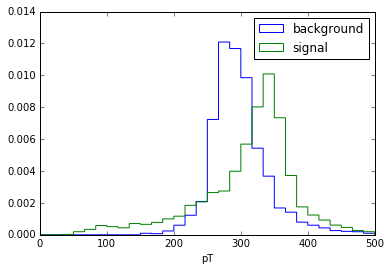

In [120]:
plt.hist(pts[ys==0], histtype="step", bins=30, range=(0, 500), label="background", normed=1)
plt.hist(pts[ys==1], histtype="step", bins=30, range=(0, 500), label="signal", normed=1)
plt.legend(loc="best")
plt.xlabel("pT")